In [1]:
from pymongo import MongoClient

# Connect to local MongoDB database
client = MongoClient("mongodb://localhost:27017")

db = client["team_5_mwdb_phase_2"]


In [2]:
# Create/access feature descriptor collection
fd_collection = db["fd_collection"]


In [18]:
import math
import cv2
import numpy as np
from scipy.stats import skew

import torch
import torchvision.transforms as transforms

import torchvision.datasets as datasets

import os
from dotenv import load_dotenv

load_dotenv()

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
# Load as tensors of shape (channels, (img_shape))
def datasetTransform(image):
    return transforms.Compose(
        [
            transforms.ToTensor()  # ToTensor by default scales to [0,1] range, the input range for ResNet
        ]
    )(image)


dataset = datasets.Caltech101(
    root=os.getenv("DATASET_PATH"),
    download=False,  # True if you wish to download for first time
    transform=datasetTransform,
)


In [5]:
# Class transform to partition image into rows x cols grid


class GridPartition:
    def __init__(self, rows, cols):
        self.rows = rows
        self.cols = cols

    def __call__(self, img):
        img_width, img_height = img.size()[1:]  # first element is channel
        cell_width = img_width // self.cols
        cell_height = img_height // self.rows

        grids = []
        for i in range(self.rows):
            for j in range(self.cols):
                left = j * cell_width
                right = left + cell_width

                top = i * cell_height
                bottom = top + cell_height

                # Slice out
                grid = img[:, left:right, top:bottom]
                grids.append(grid)

        return grids


In [6]:
def compute_color_moments(image):
    image = np.array(image)  # Convert tensor to NumPy array
    moments = []

    for channel in range(3):  # Iterate over RGB channels
        channel_data = image[:, :, channel]
        mean = np.mean(channel_data)
        std_dev = np.std(channel_data)

        # Avoiding NaN values
        skew_cubed = np.mean((channel_data - mean) ** 3)
        if skew_cubed > 0:
            skew = math.pow(skew_cubed, float(1) / 3)
        elif skew_cubed < 0:
            skew = -math.pow(abs(skew_cubed), float(1) / 3)
        else:
            skew = 0

        moments.append([mean, std_dev, skew])

    return moments


# Iterate over grid cells and return as 1-d array for easier resizing by torch
def compute_color_moments_for_grid(grid):
    color_moments = [compute_color_moments(grid_cell) for grid_cell in grid]
    return np.array(color_moments).flatten()


def combine_color_moments(grid_color_moments):
    return torch.Tensor(grid_color_moments).view(
        10, 10, 3, 3
    )  # resize as needed: 10x10 grid, 3 channels per cell, 3 moments per channel


CM_transform = transforms.Compose(
    [
        transforms.Resize((100, 300)),  # resize to H:W=100:300
        GridPartition(
            rows=10, cols=10
        ),  # partition into grid of 10 rows, 10 columns as a list
        compute_color_moments_for_grid,
        combine_color_moments,
    ]
)


In [7]:
def compute_gradient_histogram(grid_cell):
    histograms = []

    # Convert grid cell to NumPy array
    grid_array = np.array(grid_cell, dtype=np.float32)
    grid_array = grid_array.reshape(
        grid_array.shape[1], grid_array.shape[2]
    )  # ignore extra dimension

    # Compute the gradient using first-order central differences
    dx = cv2.Sobel(
        grid_array, cv2.CV_32F, dx=1, dy=0, ksize=1
    )  # first order x derivative = [-1, 0, 1]
    dy = cv2.Sobel(
        grid_array, cv2.CV_32F, dx=0, dy=1, ksize=1
    )  # first order y derivative = [-1, 0, 1]^T

    # Compute magnitude and direction of gradients
    magnitude = np.sqrt(dx**2 + dy**2)
    direction = np.arctan2(dy, dx) * 180 / np.pi  # in degrees

    # Compute HOG - 9 bins, counted across the range of -180 to 180 degrees, weighted by gradient magnitude
    histogram, _ = np.histogram(direction, bins=9, range=(-180, 180), weights=magnitude)

    histograms.append(histogram)

    return histograms


def compute_histograms_for_grid(grid):
    histograms = [compute_gradient_histogram(grid_cell) for grid_cell in grid]
    return np.array(histograms).flatten()


def combine_histograms(grid_histograms):
    return torch.Tensor(grid_histograms).view(10, 10, 9)


HOG_transform = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),  # grayscale transform
        transforms.Resize((100, 300)),  # resize to H:W=100:300
        GridPartition(
            rows=10, cols=10
        ),  # partition into grid of 10 rows, 10 columns as a list
        compute_histograms_for_grid,
        combine_histograms,
    ]
)


In [8]:
import torchvision.models as models

# Load model
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# use GPU (Nvidia)
if torch.cuda.is_available():
    dev = torch.device("cuda")
    torch.cuda.empty_cache()
else:
    dev = torch.device("cpu")

model = model.to(dev)
model.eval()  # switch to inference mode - important! since we're using pre-trained model


# Feature extractor for all layers at once


class FeatureExtractor(torch.nn.Module):
    def __init__(self, model, layers):
        super().__init__()
        self.model = model
        self.layers = layers
        self._features = {layer: None for layer in layers}  # store layer outputs here

        # Create hooks for all specified layers at once
        for layer_id in layers:
            layer = dict(self.model.named_modules())[
                layer_id
            ]  # get actual layer in the model
            layer.register_forward_hook(
                self.save_outputs_hook(layer_id)
            )  # register feature extractor hook on layer

    # Hook to save output of layer
    def save_outputs_hook(self, layer_id):
        def fn(_module, _input, output):
            self._features[layer_id] = output

        return fn

    # Forward pass returns extracted features
    def forward(self, input):
        _ = self.model(input)
        return self._features


def resnet_extractor(image):
    resized_image = (
        torch.Tensor(np.array(transforms.Resize((224, 224))(image)).flatten())
        .view(1, 3, 224, 224)
        .to(dev)
    )

    # Attach all hooks on model and extract features
    resnet_features = FeatureExtractor(model=model, layers=["avgpool", "layer3", "fc"])
    features = resnet_features(resized_image)

    avgpool_2048 = features["avgpool"]
    # Reshape the vector into row pairs of elements and average across rows
    avgpool_1024_fd = torch.mean(avgpool_2048.view(-1, 2), axis=1)

    layer3_1024_14_14 = features["layer3"]
    # Reshape the vector into 1024 rows of 196 elements and average across rows
    layer3_1024_fd = torch.mean(layer3_1024_14_14.view(1024, -1), axis=1)

    fc_1000_fd = features["fc"].view(1000)

    return (
        avgpool_1024_fd.detach().cpu().tolist(),
        layer3_1024_fd.detach().cpu().tolist(),
        fc_1000_fd.detach().cpu().tolist(),
    )


In [9]:
def get_all_fd(image_id):
    img, label = dataset[image_id]

    img_shape = np.array(img).shape

    if img_shape[0] >= 3:
        true_channels = 3
    else:
        # stacking the grayscale channel on itself thrice to get RGB dimensions
        img = torch.tensor(np.stack((np.array(img[0, :, :]),) * 3, axis=0))
        true_channels = 1

    cm_fd = CM_transform(img).tolist()
    hog_fd = HOG_transform(img).tolist()
    avgpool_1024_fd, layer3_1024_fd, fc_1000_fd = resnet_extractor(img)

    return {
        "image_id": image_id,
        "true_label": label,
        "true_channels": true_channels,
        "cm_fd": cm_fd,
        "hog_fd": hog_fd,
        "avgpool_fd": avgpool_1024_fd,
        "layer3_fd": layer3_1024_fd,
        "fc_fd": fc_1000_fd,
    }


(feature extraction for full database)

In [10]:
start = 0
stop = len(dataset)
step = 2  # even-numbered image IDs only

for idx in range(start, stop, step):
    image_fd = get_all_fd(idx)

    # Store to collection (update if existing)
    fd_collection.update_one(
        {"image_id": idx},
        {"$set": image_fd},
        upsert=True,
    )


c:\Users\rknar\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [12]:
import math


def euclidean_distance_measure(img_1_fd, img_2_fd):
    img_1_fd_reshaped = img_1_fd.flatten()
    img_2_fd_reshaped = img_2_fd.flatten()

    # Calculate Euclidean distance
    return math.dist(img_1_fd_reshaped, img_2_fd_reshaped)


In [13]:
def cosine_distance_measure(img_1_fd, img_2_fd):
    img_1_fd_reshaped = img_1_fd.flatten()
    img_2_fd_reshaped = img_2_fd.flatten()

    # Calculate dot product
    dot_product = np.dot(img_1_fd_reshaped, img_2_fd_reshaped.T)

    # Calculate magnitude (L2 norm) of the feature descriptor
    magnitude1 = np.linalg.norm(img_1_fd_reshaped)
    magnitude2 = np.linalg.norm(img_2_fd_reshaped)

    # Calculate cosine distance (similarity is higher => distance should be lower, so subtract from 1)
    cosine_similarity = dot_product / (magnitude1 * magnitude2)
    return 1 - cosine_similarity


In [14]:
from scipy.stats import pearsonr


def pearson_distance_measure(img_1_fd, img_2_fd):
    # Replace nan with 0 (color moments)
    img_1_fd_reshaped = img_1_fd.flatten()
    img_2_fd_reshaped = img_2_fd.flatten()

    # Invert and scale in half to fit the actual range [-1, 1] into the new range [0, 1]
    # such that lower distance implies more similarity
    return 0.5 * (1 - pearsonr(img_1_fd_reshaped, img_2_fd_reshaped).statistic)


In [15]:
valid_feature_models = ["cm", "hog", "avgpool", "layer3", "fc"]
valid_distance_measures = {
    "euclidean": euclidean_distance_measure,
    "cosine": cosine_distance_measure,
    "pearson": pearson_distance_measure,
}


In [19]:
def show_similar_images(
    target_image_id, k, feature_model, distance_measure, save_plots=False
):
    print(
        "Showing {} similar images for image ID {}, using {} for {} feature descriptor...".format(
            k, target_image_id, distance_measure.__name__, feature_model
        )
    )

    # store target_image itself
    min_dists = {target_image_id: 0}

    if target_image_id % 2 == 0:
        # Get target image's feature descriptors from database
        target_image = fd_collection.find_one({"image_id": target_image_id})
    else:
        # Calculate target image's feature descriptors
        target_image = get_all_fd(target_image_id)

    target_image_fd = np.array(target_image[feature_model + "_fd"])

    assert (
        feature_model in valid_feature_models
    ), "feature_model should be one of " + str(valid_feature_models)

    assert (
        distance_measure in valid_distance_measures.values()
    ), "distance_measure should be one of " + str(list(valid_distance_measures.keys()))

    # only RGB for non RGB images
    if feature_model != "hog":
        all_images = fd_collection.find({"true_channels": 3})
    else:
        all_images = fd_collection.find()

    for cur_img in all_images:
        cur_img_id = cur_img["image_id"]
        # skip target itself
        if cur_img_id == target_image_id:
            continue
        cur_img_fd = np.array(cur_img[feature_model + "_fd"])
        cur_dist = distance_measure(
            cur_img_fd,
            target_image_fd,
        )

        # store first k images irrespective of distance (so that we store no more than k minimum distances)
        if len(min_dists) < k + 1:
            min_dists[cur_img_id] = cur_dist

        # if lower distance:
        elif cur_dist < max(min_dists.values()):
            # add to min_dists
            min_dists.update({cur_img_id: cur_dist})
            # remove greatest distance by index
            min_dists.pop(max(min_dists, key=min_dists.get))

    min_dists = dict(sorted(min_dists.items(), key=lambda item: item[1]))

    fig, axs = plt.subplots(1, k + 1, figsize=(32, 12))
    for idx, (img_id, distance) in enumerate(min_dists.items()):
        cur_img, _cur_label = dataset[img_id]
        axs[idx].imshow(transforms.ToPILImage()(cur_img))
        if idx == 0:
            axs[idx].set_title(f"Target image")
        else:
            axs[idx].set_title(f"Distance: {round(distance, 3)}")
        axs[idx].axis("off")

    if save_plots:
        plt.savefig(
            f"Plots/Image_{target_image_id}_{feature_model}_{distance_measure.__name__}_k{k}.png"
        )

    plt.show()


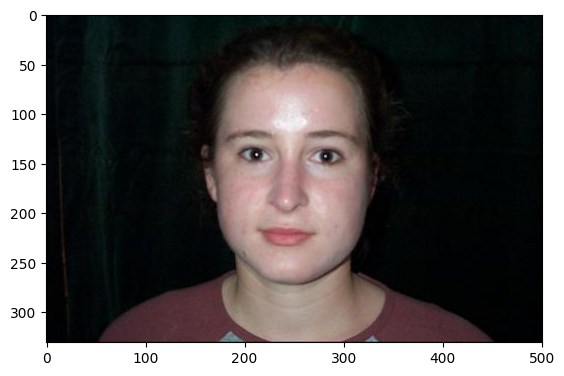

Showing 10 similar images for image ID 123, using pearson_distance_measure for fc feature descriptor...


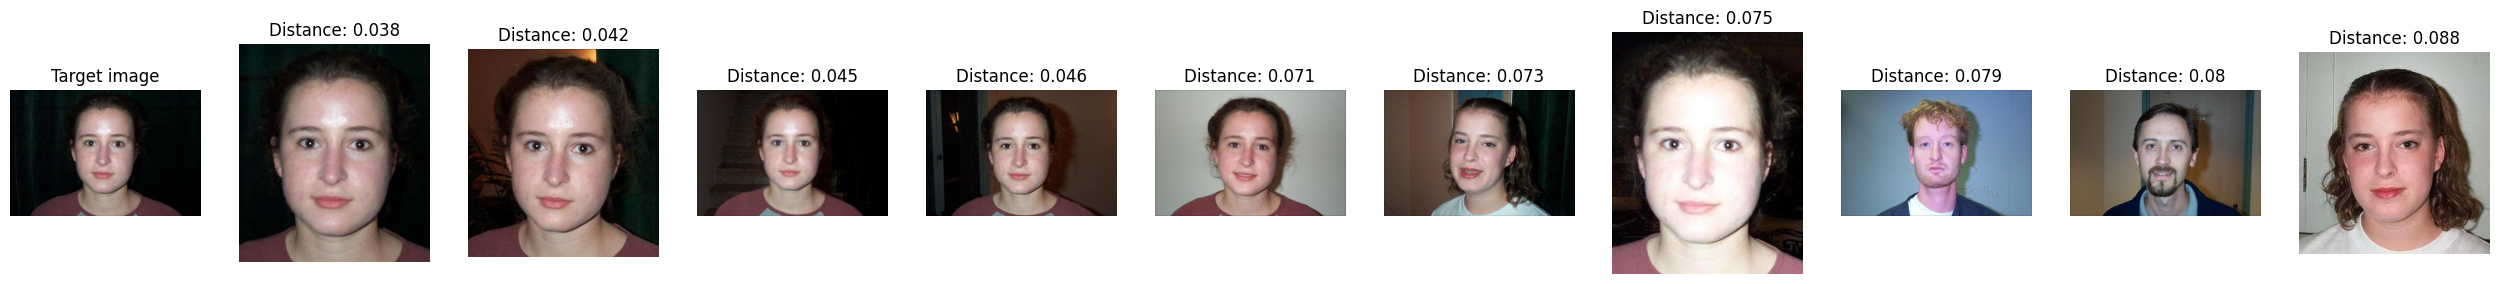

In [20]:
selected_image_id = int(input("Enter image ID: "))
sample_image, sample_label = dataset[selected_image_id]
plt.imshow(transforms.ToPILImage()(sample_image))
plt.show()

k = int(input("Enter value of k: "))
if k < 1:
    raise ValueError("k should be positive integer")

selected_feature_model = str(
    input("Enter feature model - one of " + str(valid_feature_models))
)

selected_distance_measure = valid_distance_measures[str(
    input("Enter distance measure - one of " + str(list(valid_distance_measures.keys())))
)]

show_similar_images(selected_image_id, k, selected_feature_model, selected_distance_measure, save_plots=False)
